In [51]:
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb
import scanpy as sc
import itertools
import gspread
import celltypist
import diffxpy.api as de
from typing import *             # For type annotations

from httplib2 import Http
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from scipy.stats import zscore
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats
from collections import Counter
from itertools import combinations
from kneed import KneeLocator
import metacells as mc
from scipy.stats import mannwhitneyu


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')  # low dpi (dots per inch) yields small inline figures

scanpy==1.9.8 anndata==0.9.2 umap==0.5.6 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.1 pynndescent==0.5.4


In [239]:
def draw_barplot(adata, genes, colors=['red', 'green'], tbl_name=""):
    plotdata = adata.copy()
    gene_df = pd.DataFrame(plotdata[:, genes].X.todense(), columns=genes)
    gene_df['Treatment'] = pd.Categorical(plotdata.obs.Treatment.values, categories=['Isotype', 'Depletion'], ordered=True)
    grouped = gene_df.groupby('Treatment').agg(['mean', 'std', 'count'])
    if tbl_name:
        grouped.to_csv('depletion_dges/' + tbl_name + '.csv')
    fig, axes = plt.subplots(1, len(genes), figsize=(0.25 + len(genes) * 1, 2.5))
    bar_width = 1
    index = np.arange(len(grouped)) 
    for i in range(len(genes)):
        col = genes[i]
        axes[i].bar(index, grouped[col]['mean'], bar_width, label=f'{col} Mean', color=colors, 
                    edgecolor="black", linewidth=0.5, error_kw={'elinewidth': 0.5},
                    yerr=grouped[col]['std'] / np.sqrt(grouped[col]['count']), capsize=1)
        if i == 0:
            axes[i].set_ylabel('Log normalized expression', size=12)
        axes[i].set_title(col, size=14)
        axes[i].set_xticks(index)
        axes[i].set_xticklabels(grouped.index, rotation=90, size=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].grid(False)
        axes[i].spines['top'].set_visible(False)  # Hide the top spine
        axes[i].spines['right'].set_visible(False)  # Hide the right spine
    fig.tight_layout()
    return fig

def draw_barplot_batch(adata, genes, colors=['red', 'green'], tbl_name=""):
    plt_colors = [colors[0]] * 4 + [colors[1]] * 3
    plotdata = adata.copy()
    gene_df = pd.DataFrame(plotdata[:, genes].X.todense(), columns=genes)
    gene_df['Batch.Set.ID'] = pd.Categorical(plotdata.obs['Batch.Set.ID'].values)
    grouped = gene_df.groupby('Batch.Set.ID').agg(['mean', 'std', 'count'])
    if tbl_name:
        grouped.to_csv('depletion_dges/' + tbl_name + '.csv')
    fig, axes = plt.subplots(1, len(genes), figsize=(0.25 + len(genes) * 2, 2.5))
    bar_width = 1
    index = np.arange(len(grouped)) 
    for i in range(len(genes)):
        col = genes[i]
        axes[i].bar(index, grouped[col]['mean'], bar_width, label=f'{col} Mean', color=plt_colors, 
                    edgecolor="black", linewidth=0.5, error_kw={'elinewidth': 0.5},
                    yerr=grouped[col]['std'] / np.sqrt(grouped[col]['count']), capsize=1)
        if i == 0:
            axes[i].set_ylabel('Log normalized expression', size=12)
        axes[i].set_title(col, size=14)
        axes[i].set_xticks(index)
        axes[i].set_xticklabels(grouped.index, rotation=90, size=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].grid(False)
        axes[i].spines['top'].set_visible(False)  # Hide the top spine
        axes[i].spines['right'].set_visible(False)  # Hide the right spine
    fig.tight_layout()
    return fig

### loading metadata

In [2]:
SPREADSHEET_ID = "1M4EdSuoEF1vCFF6KPgTzMnoytimIJ583v4kVL0_OpuA"
RANGE_NAME = "Sheet1"
CREDS_PATH = '/home/orimosko/credentials.json'
DROP_COLS = ["Tapestation mean peak", "QBit ng/ul", "QC1", "QC2", "FACS machine", "PCR num cycles", 
             "RT_primer concentration", "Pool barcode number", "R1 length", "R2 design"]


def load_sheet(spreadsheet_id, range_name):
    scope = 'https://www.googleapis.com/auth/spreadsheets.readonly'
    creds = ServiceAccountCredentials.from_json_keyfile_name(CREDS_PATH, scope)
    service = build('sheets', 'v4', http=creds.authorize(Http()))
    gsheet = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    header = gsheet.get('values', [])[0]
    values = gsheet.get('values', [])[1:]
    all_data = []
    for col_id, col_name in enumerate(header):
        column_data = []
        for row in values:
            try:
                column_data.append(row[col_id])
            except IndexError:
                column_data.append("")
        ds = pd.Series(data=column_data, name=col_name)
        all_data.append(ds)
    df = pd.concat(all_data, axis=1)
    return df

metadata_df = load_sheet(SPREADSHEET_ID, RANGE_NAME)
metadata_df.drop(columns=DROP_COLS, inplace=True)
metadata_df.set_index("Amp.Batch.ID", inplace=True)

file_cache is only supported with oauth2client<4.0.0
Attempting refresh to obtain initial access_token
Refreshing access_token


In [3]:
cell_barcode_df = pd.read_csv("/mc_disk2/data/ori_backup/Projects/MCLab/preprocessing/OLD_barcode_list.csv")
old_barcode_dict = dict(zip(cell_barcode_df["cell_barcode"], cell_barcode_df["well_position"]))
cell_barcode_df = pd.read_csv("/mc_disk2/data/ori_backup/Projects/MCLab/preprocessing/cell_barcode_list.csv")
barcode_dict = dict(zip(cell_barcode_df["cell_barcode"], cell_barcode_df["well_position"]))
del(cell_barcode_df)

### Loading data

In [4]:
file_list = []
ampbatches = []
top_dir = "/mc_disk2/data/counts/"
for sub_dir in os.listdir(top_dir):
    file_dir = os.path.join(top_dir, sub_dir)
    if os.path.isdir(file_dir) and sub_dir[:2] == "SB":
        for f in os.listdir(file_dir):
            if f[-7:] == ".tsv.gz":
                file_list.append(os.path.join(file_dir, f))
                ampbatches.append(f.split("_")[0])

In [5]:
cond = [metadata_df.loc[ab, "Owner"] == "Sandra" and
        ("I" in metadata_df.loc[ab, "Batch.Set.ID"] or "D" in metadata_df.loc[ab, "Batch.Set.ID"]) and
        metadata_df.loc[ab, 'Cell_type'] in ['EPCAM', 'CD31'] and
        metadata_df.loc[ab, 'Age'] == '12w' and 
        ab != "AB1189" and ab != "AB1188" for ab in ampbatches]
file_list = np.array(file_list)[cond]
file_list.sort()
ampbatches = np.array(ampbatches)[cond]
ampbatches.sort()

In [6]:
ampbatches.sort()

In [7]:
print(", ".join(list(ampbatches)))

AB1135, AB1136, AB1142, AB1143, AB1164, AB1167, AB1169, AB1172, AB1174, AB1176, AB1177, AB1182, AB1187, AB1195, AB1197, AB1200, AB1204


In [8]:
metadata_df = metadata_df.loc[ampbatches]
for col in metadata_df.columns:
    if np.all(metadata_df[col] == ""):
        metadata_df.drop(columns=col, inplace=True)

In [9]:
for i in tqdm(range(len(file_list))):
    f = file_list[i]
    ab = ampbatches[i]
    if not ab in f:
        raise ValueError("File to AB mismatch!! Critical")
    plate_ad = sc.read_umi_tools(f)
    plate_ad.obs["Amp.Batch.ID"] = ab
    if "old_breast" in f or "SB001" in f:
        plate_ad.obs["Well_position"] = [old_barcode_dict[x] for x in plate_ad.obs_names]
    else:
        plate_ad.obs["Well_position"] = [barcode_dict[x] for x in plate_ad.obs_names]
    plate_ad.obs_names = [ab + "_" + pos for pos in plate_ad.obs["Well_position"]]
    df_row = metadata_df.loc[ab]
    for col, val in df_row.items():
        if col not in ["Wells", "Empty wells"]:
            plate_ad.obs[col] = val.replace(" ", "")
        elif col == "Wells":
            if val != "ALL":
                raise ValueError("Ori hasn't prepared for this yet! Call him")
        elif col == "Empty wells":
                empty_wells = []
                for part in val.split(","):
                    if len(part) == 1:
                        empty_wells += [part + str(num) for num in range(1,25)]
                    elif part[1] == "-":
                        for letter in range(ord(part[0]), ord(part[2]) + 1):
                            empty_wells += [chr(letter) + str(num) for num in range(1,25)]
                    else:
                        empty_wells += [part[0] + str(i) 
                                        for i in range(int(part[1:].split("-")[0]), int(part.split("-")[1]) + 1)]
                plate_ad.obs["Empty_well"] = np.isin(plate_ad.obs.Well_position, empty_wells)
    if i == 0:
        adata = plate_ad
    else:
        adata = ad.concat([adata, plate_ad], join="outer", fill_value=0)

100%|██████████| 17/17 [00:01<00:00,  8.86it/s]


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'Amp.Batch.ID' as categorical
... storing 'Well_position' as categorical
... storing 'Seq.Batch.ID' as categorical
... storing 'Date of sequencing' as categorical
... storing 'Batch.Set.ID' as categorical
... storing 'Owner' as categorical
... storing 'Date of sort' as categorical
... storing 'Plate description' as categorical
... storing 'Species' as categorical
... storing 'Strain' as categorical
... storing 'condition' as categorical
... storing 'Treatment' as categorical
... storing 'Tissue' as categorical
... storing 'Age' as categorical
... storing 'Cell_type' as categorical
... storing 'comment' as categorical
... storing 'Replicate' as categorical


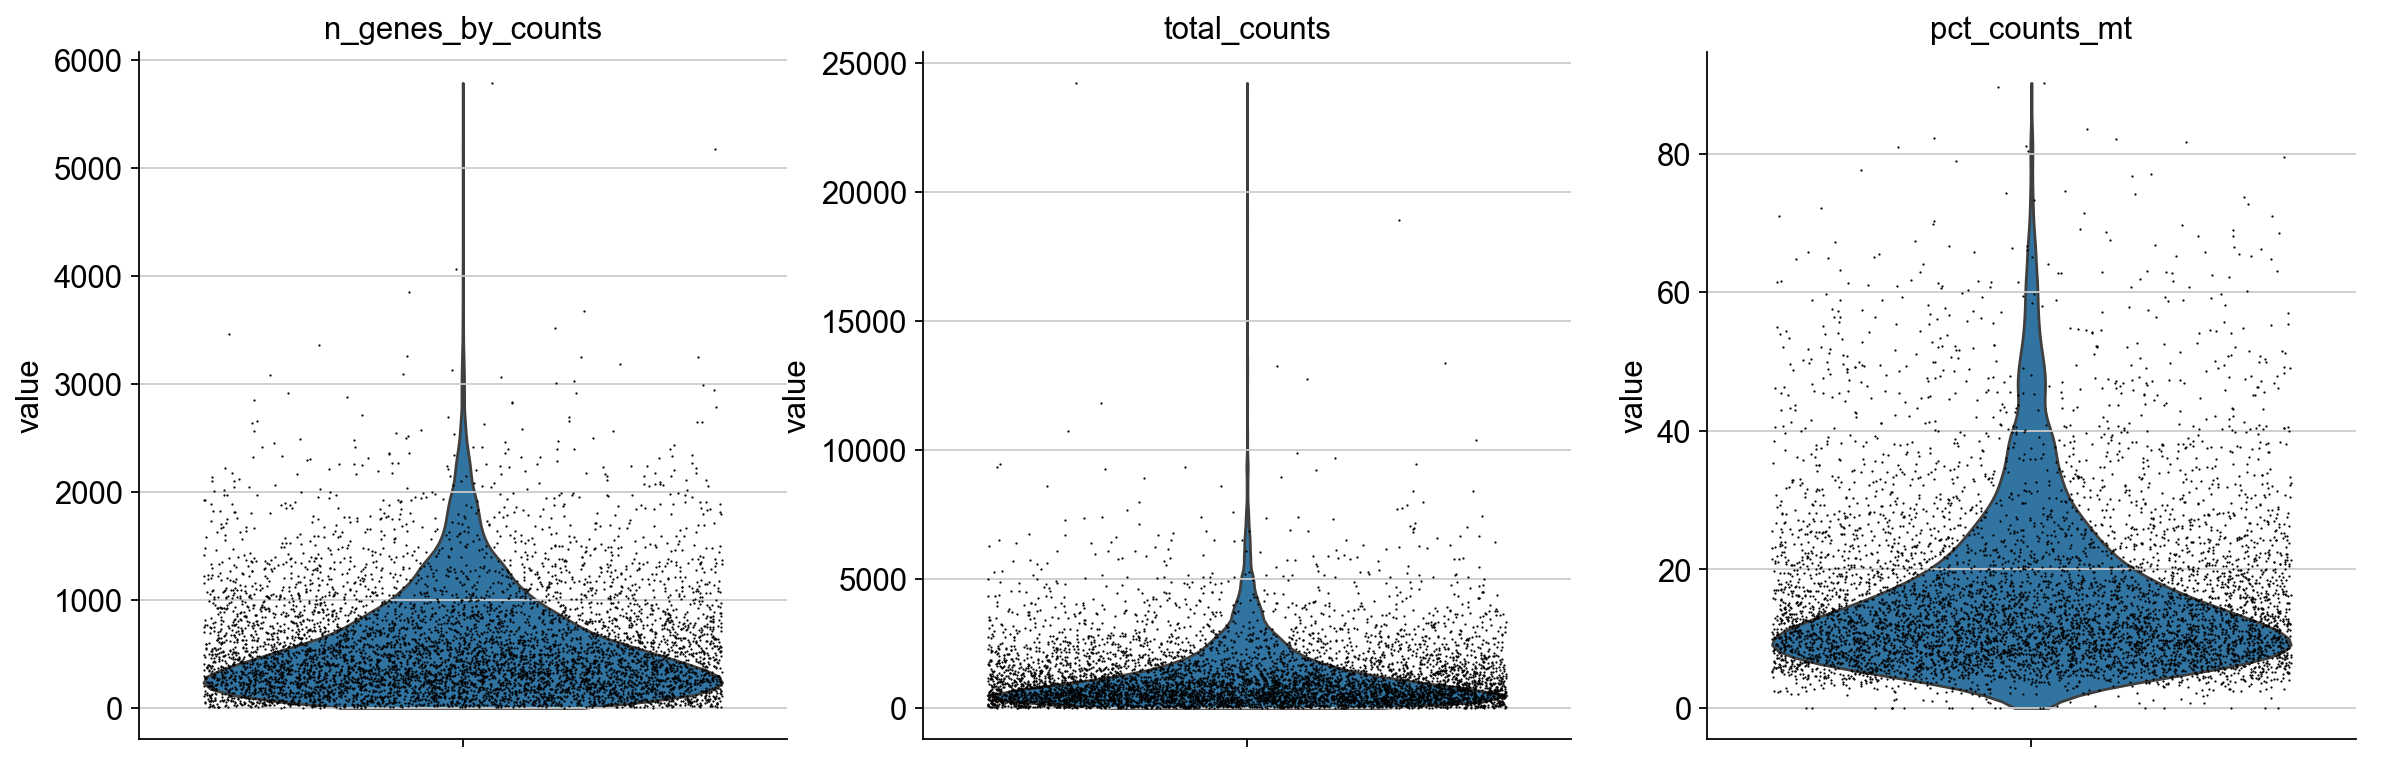

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [12]:
adata = adata[adata.obs.pct_counts_mt < 30]

In [13]:
adata.shape

(5733, 23152)

In [14]:
[v for v in adata.var_names if "Hb" in v]

['Hba-a1', 'Hba-a2', 'Hba-ps4', 'Hbb-bs', 'Hbb-bt', 'Hbegf', 'Hbp1', 'Hbs1l']

In [15]:
adata = adata[adata[:,['Hba-a1', 'Hba-a2', 'Hba-ps4', 'Hbb-bs', 'Hbb-bt']].X.sum(axis=1) <= 1]

In [16]:
adata.shape

(5625, 23152)

normalizing counts per cell
    finished (0:00:00)


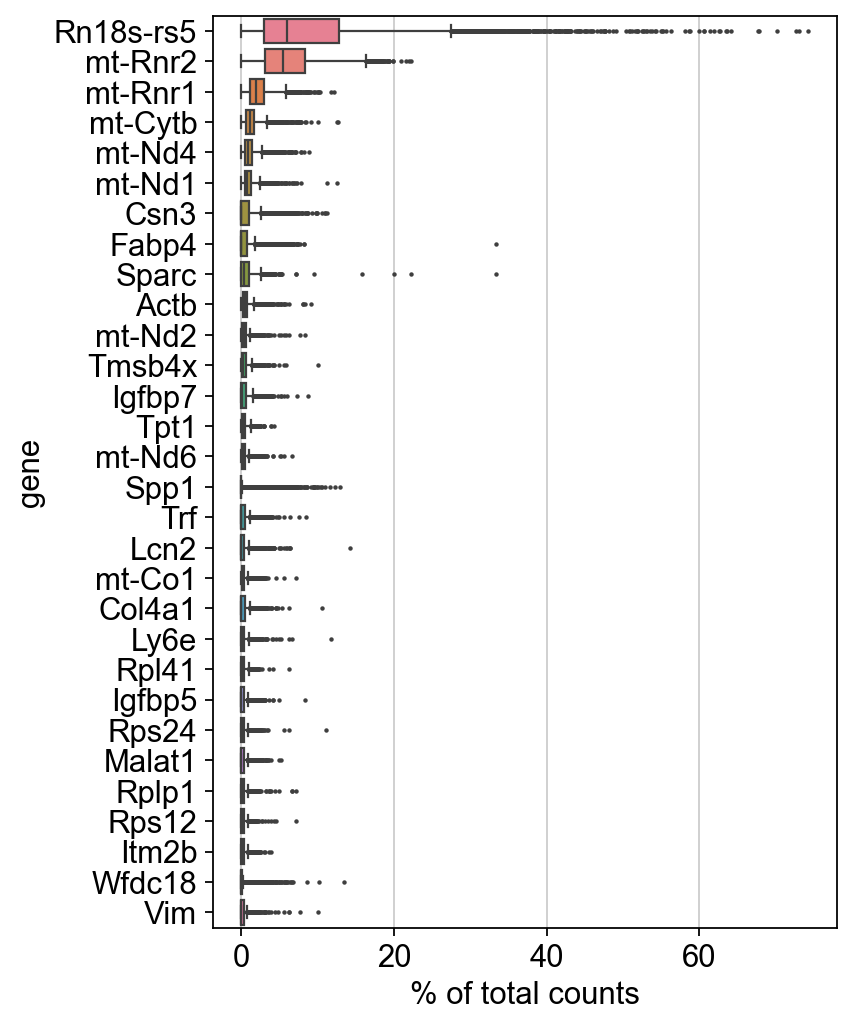

In [17]:
sc.pl.highest_expr_genes(adata)

In [18]:
adata.obs["count_scale"] = ["under 100" if c < 100 else 
                            "100-200" if 100 <= c < 200 else
                            "200-300" if 200 <= c < 300 else
                            "300-8000" if 300 <= c < 8000 else
                            "8000-10000" if 8000 <= c < 10000 else
                            "over 10000" for c in adata.obs.total_counts]
adata.obs["count_scale"] = pd.Categorical(adata.obs["count_scale"], ordered=True)
count_categories = [cat for cat in ["under 100", "100-200", "200-300", "300-8000", "8000-10000", "over 10000"] 
                    if cat in adata.obs.count_scale.values.categories]
adata.obs["count_scale"] = adata.obs["count_scale"].cat.reorder_categories(count_categories)

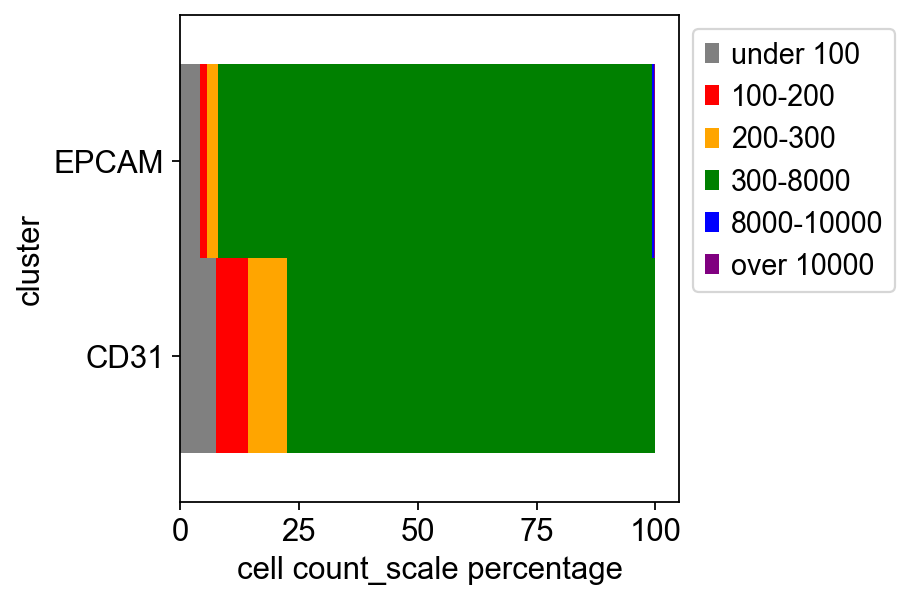

In [19]:
df = pd.DataFrame(index=np.unique(adata.obs["Cell_type"].values),
                  data=[adata[adata.obs["Cell_type"].values == i, :].obs["count_scale"].value_counts() 
                        for i in np.unique(adata.obs["Cell_type"].values)], dtype=int)
df = df[count_categories]
df.sort_index(inplace=True)
for i in df.index:
    df.loc[i] = 100 * df.loc[i] / np.nansum(df.loc[i])
ax = df.plot(kind="barh", stacked=True, ylabel="cluster", width=1, 
             color=["gray", "red", "orange", "green", "blue", "purple", 'pink'])
ax.set_xlabel("cell count_scale percentage")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)
plt.show()

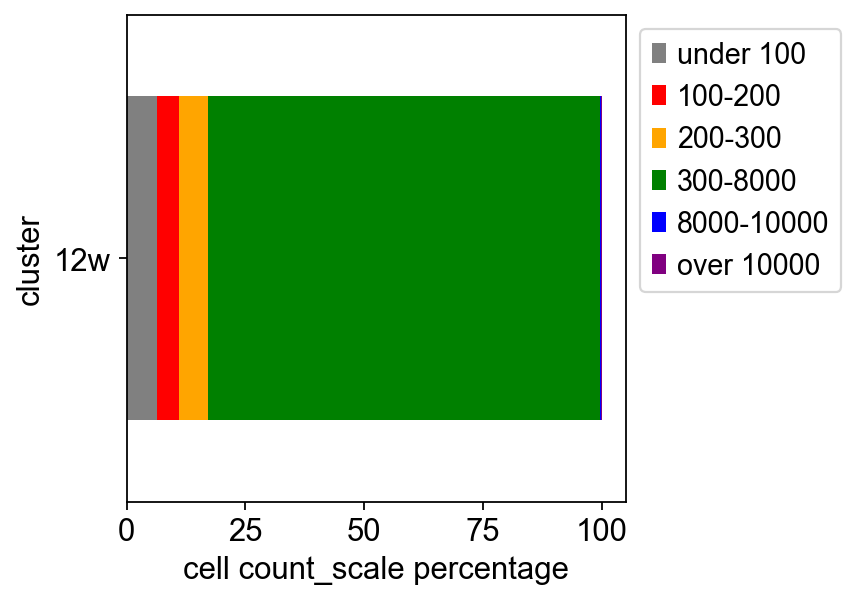

In [20]:
df = pd.DataFrame(index=np.unique(adata.obs["Age"].values),
                  data=[adata[adata.obs["Age"].values == i, :].obs["count_scale"].value_counts() 
                        for i in np.unique(adata.obs["Age"].values)], dtype=int)
df = df[count_categories]
df.sort_index(inplace=True)
for i in df.index:
    df.loc[i] = 100 * df.loc[i] / np.nansum(df.loc[i])
ax = df.plot(kind="barh", stacked=True, ylabel="cluster", width=1, 
             color=["gray", "red", "orange", "green", "blue", "purple", 'pink'])
ax.set_xlabel("cell count_scale percentage")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)
plt.show()

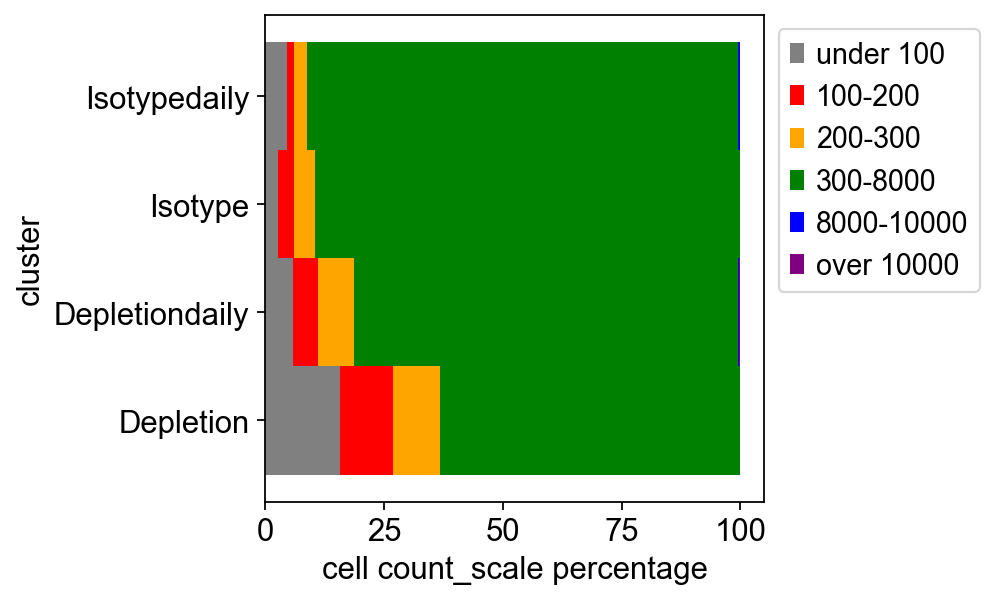

In [23]:
df = pd.DataFrame(index=np.unique(adata.obs["Treatment"].values),
                  data=[adata[adata.obs["Treatment"].values == i, :].obs["count_scale"].value_counts() 
                        for i in np.unique(adata.obs["Treatment"].values)])
df = df[count_categories]
df.sort_index(inplace=True)
for i in df.index:
    df.loc[i] = 100 * df.loc[i] / np.nansum(df.loc[i])
ax = df.plot(kind="barh", stacked=True, ylabel="cluster", width=1, 
             color=["gray", "red", "orange", "green", "blue", "purple", 'pink'])
ax.set_xlabel("cell count_scale percentage")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.grid(False)
plt.show()

In [24]:
adata.write_h5ad("/mc_disk2/data/h5ads/breast/depletion_singlets_epiepcam.h5ad")

# Post QC

In [293]:
adata = sc.read_h5ad("/mc_disk2/data/h5ads/breast/depletion_singlets_epiepcam.h5ad")

In [294]:
adata.obs.Treatment = adata.obs.Treatment.str.replace('Depletiondaily', 'Depletion').replace('Isotypedaily', 'Isotype')

In [410]:
epi_adata = adata[adata.obs.Cell_type == "EPCAM"]

In [411]:
epi_adata.shape

(2092, 23152)

In [412]:
sc.pp.filter_cells(epi_adata, min_counts=300)
sc.pp.filter_cells(epi_adata, max_counts=6000)

filtered out 166 cells that have less than 300 counts
filtered out 60 cells that have more than 6000 counts


In [413]:
epi_adata.shape

(1866, 23152)

In [414]:
sc.pp.filter_genes(epi_adata, min_cells=3)

filtered out 9091 genes that are detected in less than 3 cells


In [415]:
epi_adata.raw = epi_adata

In [416]:
epi_adata.layers['counts'] = epi_adata.X.copy()

In [417]:
sc.pp.normalize_total(epi_adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [418]:
sc.pp.log1p(epi_adata)

In [419]:
epi_adata.layers['scaled'] = sc.pp.scale(epi_adata, copy=True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [420]:
epi_adata.obs[['Age', 'Treatment', 'Cell_type']].value_counts(sort=False)

Age  Treatment  Cell_type
12w  Depletion  EPCAM        1021
     Isotype    EPCAM         845
Name: count, dtype: int64

In [421]:
epi_adata.obs[['Age', 'Treatment', ]].value_counts(sort=False)

Age  Treatment
12w  Depletion    1021
     Isotype       845
Name: count, dtype: int64

In [422]:
epi_adata.obs[['Age', 'Treatment', 'Cell_type', 'Replicate']].drop_duplicates()[['Age', 'Treatment', 'Cell_type']].value_counts(sort=False)

Age  Treatment  Cell_type
12w  Depletion  EPCAM        2
     Isotype    EPCAM        2
Name: count, dtype: int64

In [423]:
sc.pp.highly_variable_genes(epi_adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [424]:
sum(epi_adata.var.highly_variable)

3271

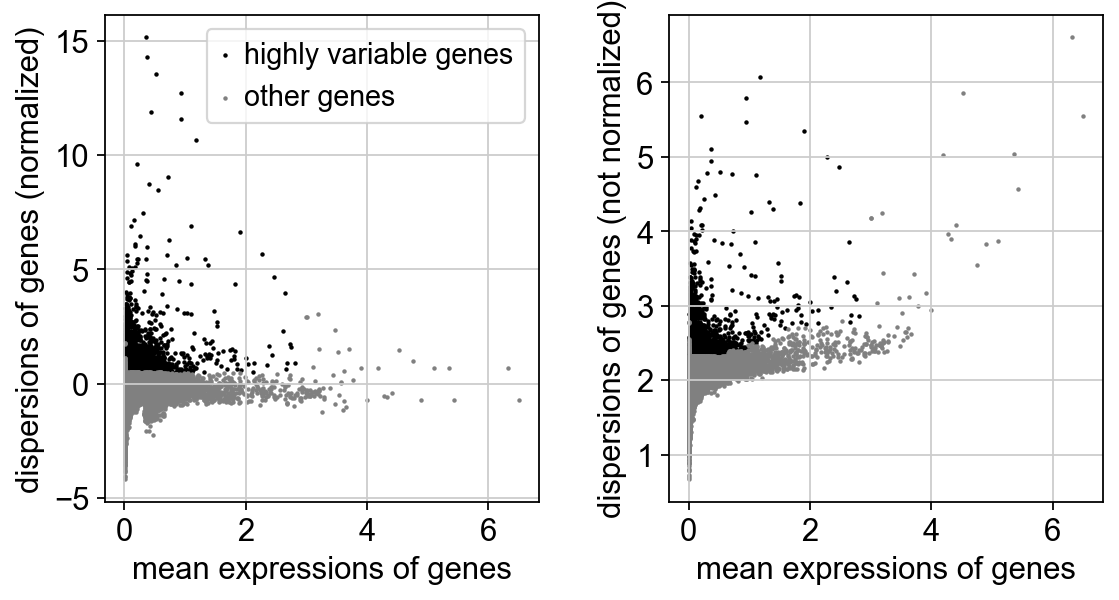

In [425]:
sc.pl.highly_variable_genes(epi_adata)

In [426]:
sc.tl.pca(epi_adata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'Treatment' as categorical


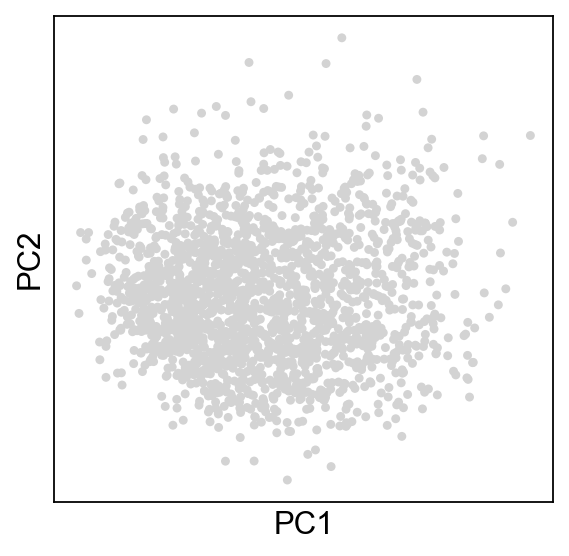

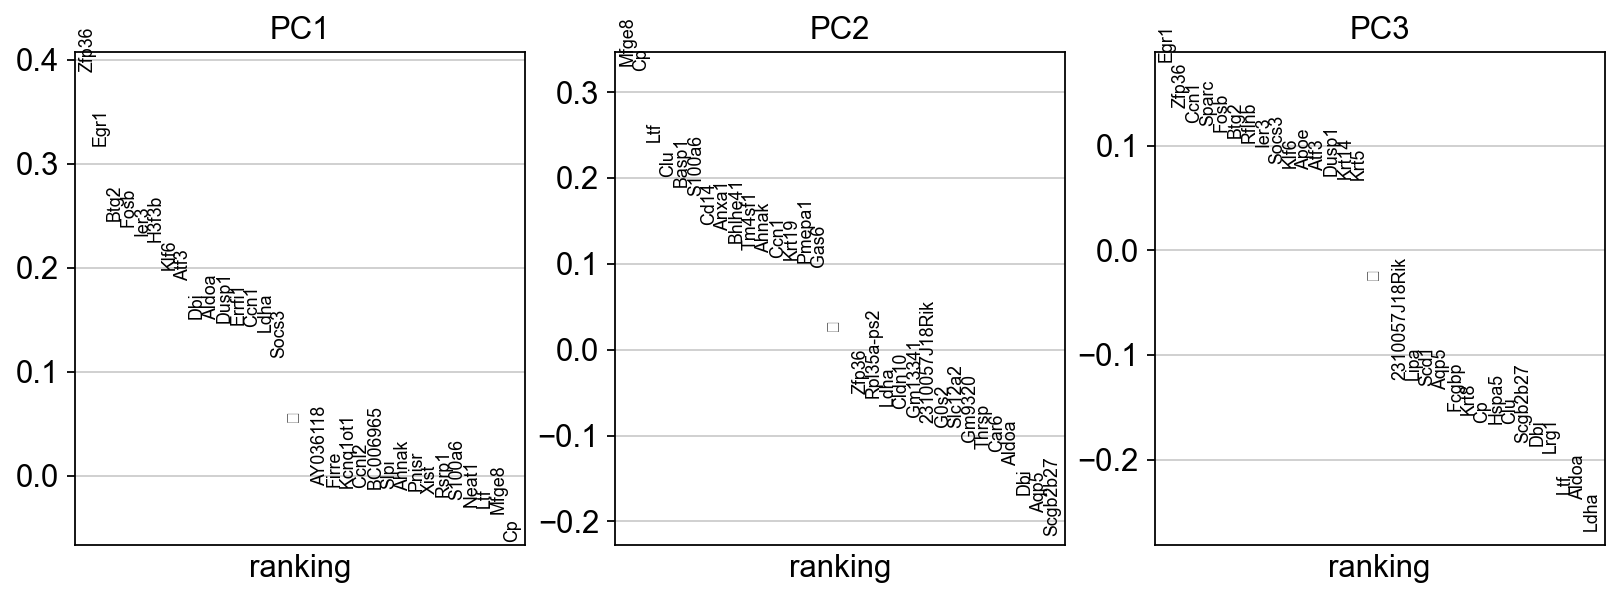

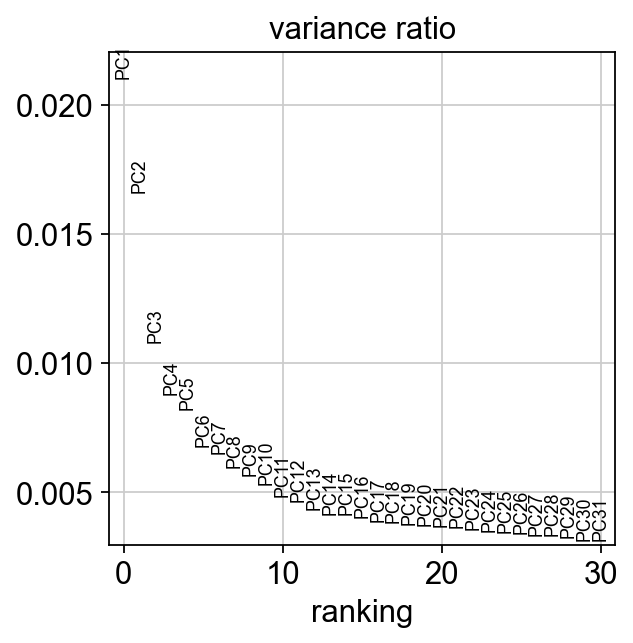

In [427]:
sc.pl.pca_overview(epi_adata)

In [428]:
sc.pp.neighbors(epi_adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [429]:
sc.tl.umap(epi_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [430]:
sc.tl.leiden(epi_adata, resolution=0.3)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


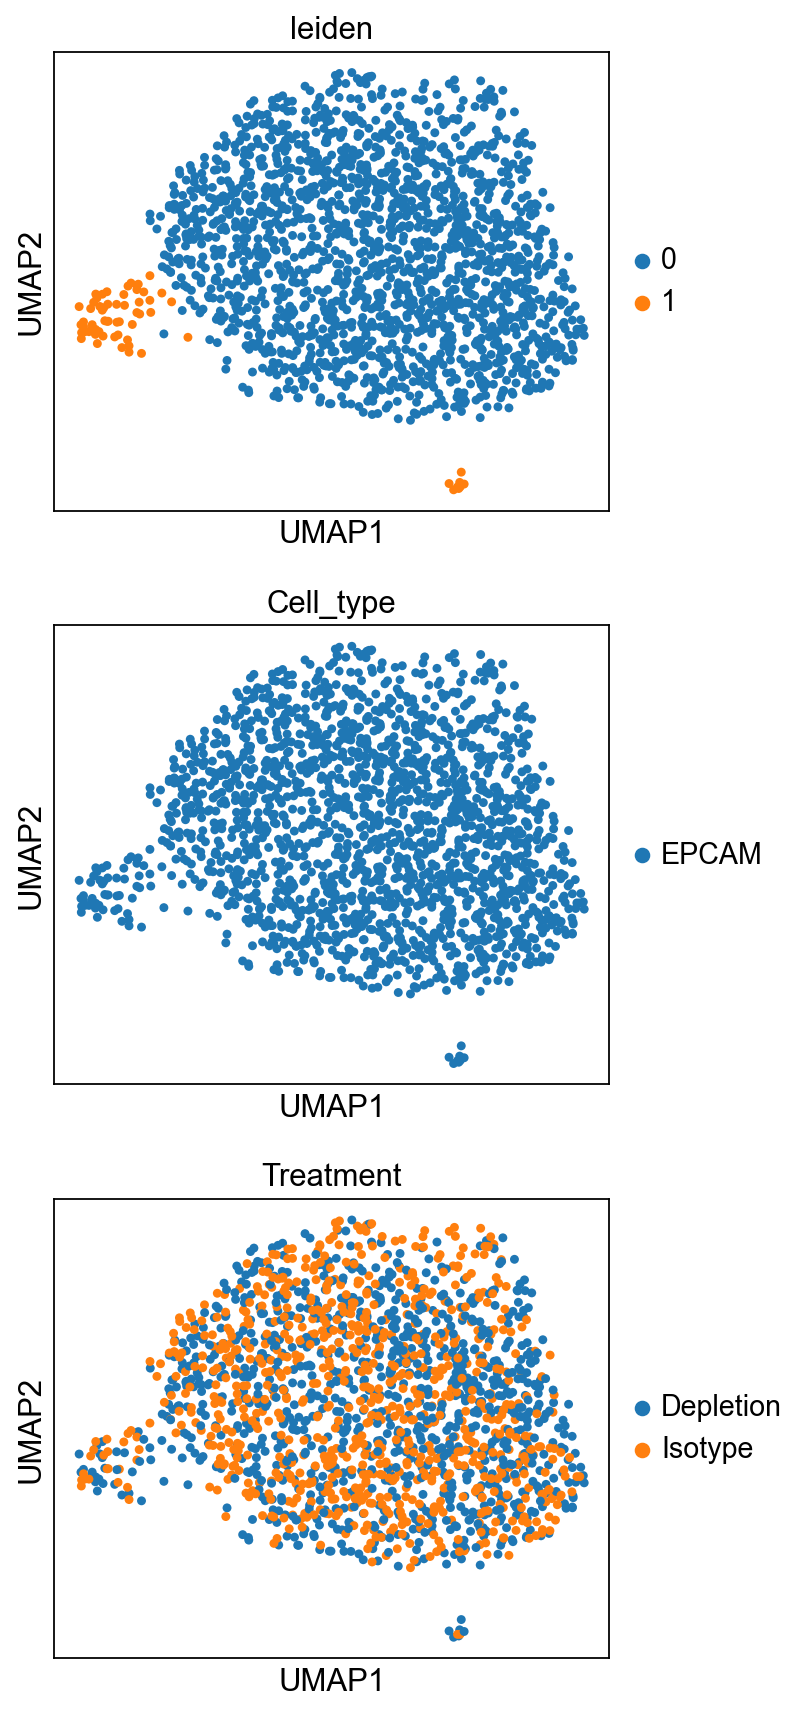

In [431]:
sc.pl.umap(epi_adata, color=['leiden', 'Cell_type', 'Treatment'], ncols=1)

In [432]:
sc.tl.rank_genes_groups(epi_adata, groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [433]:
pd.DataFrame(epi_adata.uns["rank_genes_groups"]["names"][0:25])

0        1
0       Wfdc18    Rflnb
1        Cldn3    Sparc
2          Dbi     Krt5
3         Csn3   Tmsb10
4        Plet1    Lima1
5        Lalba     Cav2
6         Lcn2     Cbr2
7        Dkkl1     Apoe
8         Xbp1     Perp
9       Mansc1     Sgk1
10       Kcnn4   Atp1b3
11         Pgp     Tril
12     Serinc3   Lgals7
13       Bspry     Jag2
14       Krt18   Pmepa1
15      Ythdc1  Bhlhe41
16  St6galnac6   Lgals9
17       Clic6    Krt14
18        Scd1    Itga6
19       Mgst1     Cnn2
20       Fcgbp      Dsp
21        Chka   Marcks
22     Bhlha15     Sfr1
23        Glb1     Rbp1
24      Mfsd4a     Actb

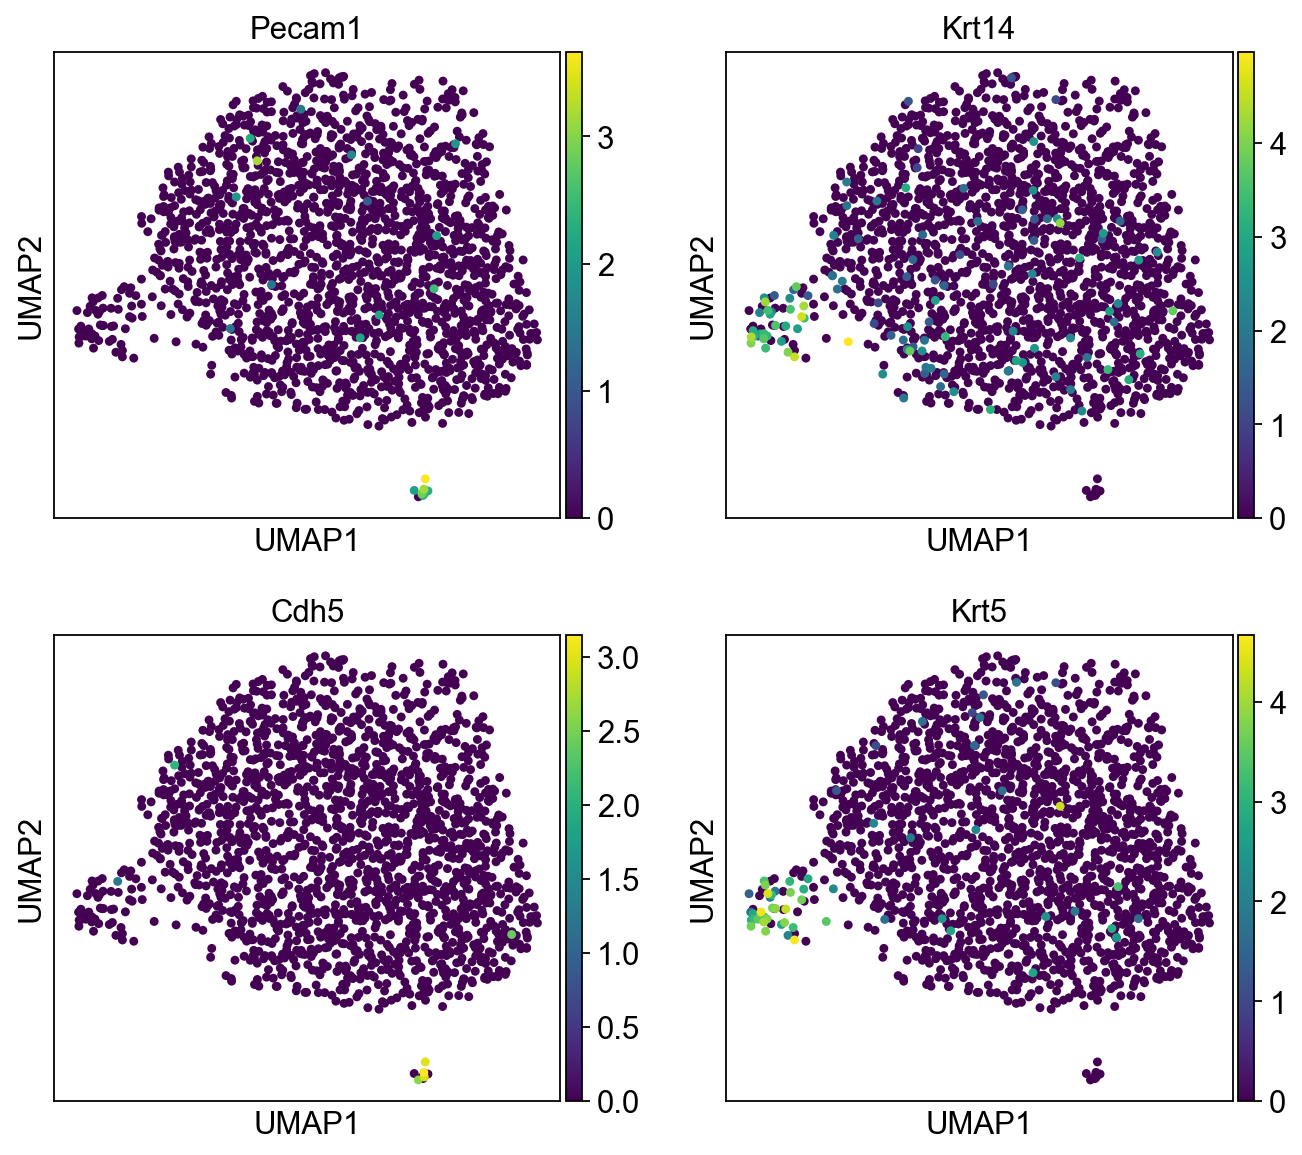

In [434]:
sc.pl.umap(epi_adata, color=['Pecam1', 'Krt14', 'Cdh5', 'Krt5'], ncols=2, use_raw=False, save="depletion_epi_genes.pdf")

In [436]:
epi_adata.obs['annots'] = ["Tumor" if a == "0" else "Bad" for a in epi_adata.obs.leiden]

... storing 'annots' as categorical


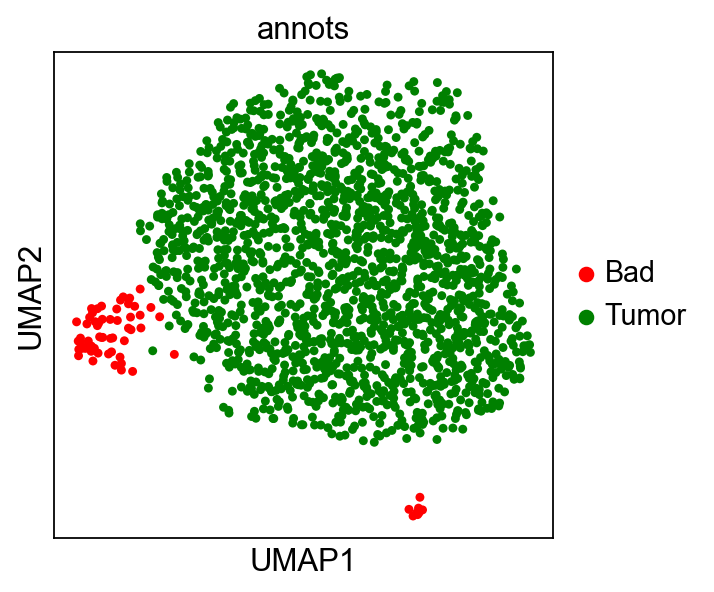

In [437]:
sc.pl.umap(epi_adata, color=['annots'], palette=['red', 'green'], save="depletion_epi_annots.pdf")

In [459]:
epi_adata = epi_adata[epi_adata.obs.leiden == "0"]

In [460]:
sc.pp.filter_genes(epi_adata, min_counts=20)
sc.tl.rank_genes_groups(epi_adata, groupby='Treatment', method='t-test', use_raw=False)

filtered out 138 genes that are detected in less than 20 counts
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [461]:
epi_gene_df = sc.get.rank_genes_groups_df(epi_adata, group='Isotype')

In [462]:
epi_gene_df.to_excel('depletion_dges/epi_new.xlsx')

In [471]:
epi_gene_df[(epi_gene_df.pvals_adj < 0.05 )& (epi_gene_df.logfoldchanges > 0)].names.values

array(['Rn18s-rs5', 'mt-Rnr2', 'mt-Rnr1', 'Txnip', 'Ccni', 'Eef2',
       'Trps1', 'Slc12a2', 'Atp6v1b1', 'Stx5a', 'Csn1s1', 'Ddx5', 'Nfix',
       'Acox1', 'Erbin', 'Tcim', 'Ehf', 'Srebf1', 'Alyref', 'Prickle2',
       'Tmem250-ps', 'Uba2', 'Mtmr10', 'Wasf2', 'Tsc22d3', 'Tob1', 'Per1',
       'Chil1', 'Tcf7l2', 'Aldoa', 'Gm2a', 'Cdc73', 'App', 'S100a9',
       'Arid2', 'Dynll2', 'Ppp1cb', 'Glyr1', 'Appl2', 'Acly', 'Mt1',
       'Pmepa1', 'Dnaja2', 'Nfkbia', 'Pim3', 'Zcchc17', 'Ppp3ca', 'Ash1l',
       'Tmbim6', 'Tle3', 'Ptms', 'Cited4', 'Pnpla2', 'Tyw1', 'Rbm47',
       'Nhsl1', 'Ehbp1', 'Dag1', 'Abca1', 'Cfap410', 'Reep5', 'Tnrc6b',
       'Nr4a1', 'Pabpc1', 'Hsd17b10', 'Cck', 'Tnrc6a', 'Srsf9', 'Zbtb20',
       'Igfbp5', 'Ppp2r3a', 'Nipsnap3b', 'Tax1bp1', 'Clic6', 'Ddx3x',
       'Ngp', 'Mxd4', 'Iqsec1', 'Tmbim1', 'Gata3', 'Sox9'], dtype=object)

In [472]:
epi_plot_genes = [
    "Ccni", "Ddx3x", # Related to G1->S transition
    "Nr4a1", #https://www.nature.com/articles/ncomms4388
    "Pim3", #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10854964/
]

In [473]:
epi_gene_df.set_index('names').loc[epi_plot_genes]

scores  logfoldchanges         pvals  pvals_adj
names                                                   
Ccni   5.776820        0.797016  9.093598e-09   0.000003
Ddx3x  3.298182        0.447645  9.931585e-04   0.047734
Nr4a1  3.385653        0.650144  7.273048e-04   0.038224
Pim3   3.580734        1.057378  3.540386e-04   0.022215

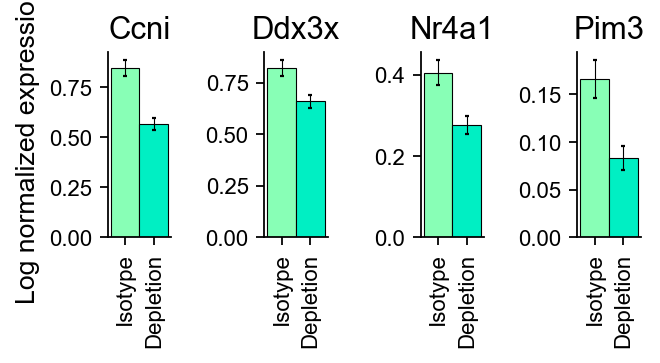

In [474]:
f = draw_barplot(epi_adata,
                 epi_plot_genes, 
                 ['#88ffb6', '#00efc3'], tbl_name='epi_genes_new')
f.savefig('revision_figs/epi_genes_new.pdf')

In [379]:
endo_adata = adata[adata.obs.Cell_type == "CD31"]

In [380]:
endo_adata.shape

(3533, 23152)

In [381]:
sc.pp.filter_cells(endo_adata, min_counts=300)
sc.pp.filter_cells(endo_adata, max_counts=6000)

filtered out 796 cells that have less than 300 counts
filtered out 18 cells that have more than 6000 counts


In [382]:
endo_adata.shape

(2719, 23152)

In [383]:
sc.pp.filter_genes(endo_adata, min_cells=3)

filtered out 8446 genes that are detected in less than 3 cells


In [384]:
endo_adata.raw = endo_adata

In [385]:
endo_adata.layers['counts'] = endo_adata.X.copy()

In [386]:
sc.pp.normalize_total(endo_adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [387]:
sc.pp.log1p(endo_adata)

In [388]:
endo_adata.layers['scaled'] = sc.pp.scale(endo_adata, copy=True).X

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [389]:
endo_adata.obs[['Age', 'Treatment', 'Cell_type']].value_counts(sort=False)

Age  Treatment  Cell_type
12w  Depletion  CD31         1450
     Isotype    CD31         1269
Name: count, dtype: int64

In [390]:
endo_adata.obs[['Age', 'Treatment', ]].value_counts(sort=False)

Age  Treatment
12w  Depletion    1450
     Isotype      1269
Name: count, dtype: int64

In [391]:
endo_adata.obs[['Age', 'Treatment', 'Cell_type', 'Replicate']].drop_duplicates()[['Age', 'Treatment', 'Cell_type']].value_counts(sort=False)

Age  Treatment  Cell_type
12w  Depletion  CD31         4
     Isotype    CD31         3
Name: count, dtype: int64

In [392]:
sc.pp.highly_variable_genes(endo_adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [393]:
sum(endo_adata.var.highly_variable)

3485

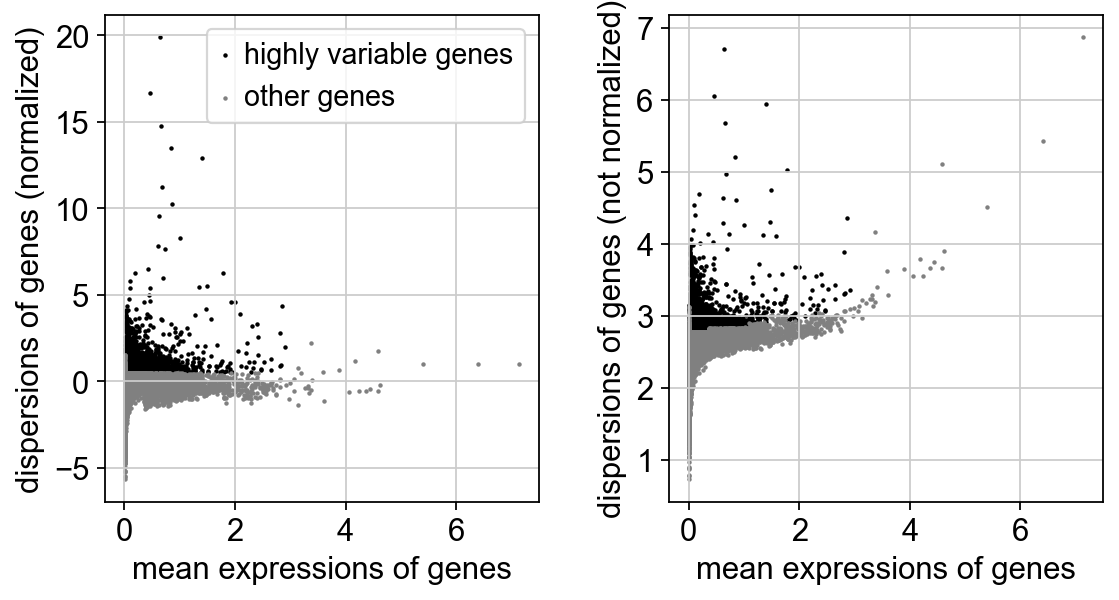

In [394]:
sc.pl.highly_variable_genes(endo_adata)

In [395]:
sc.tl.pca(endo_adata, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'Treatment' as categorical


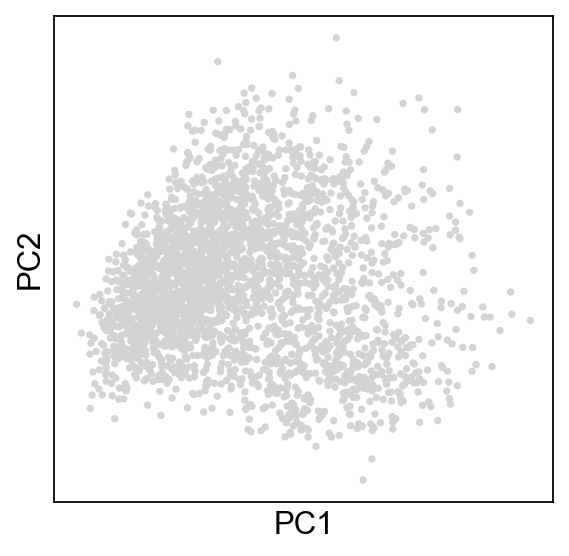

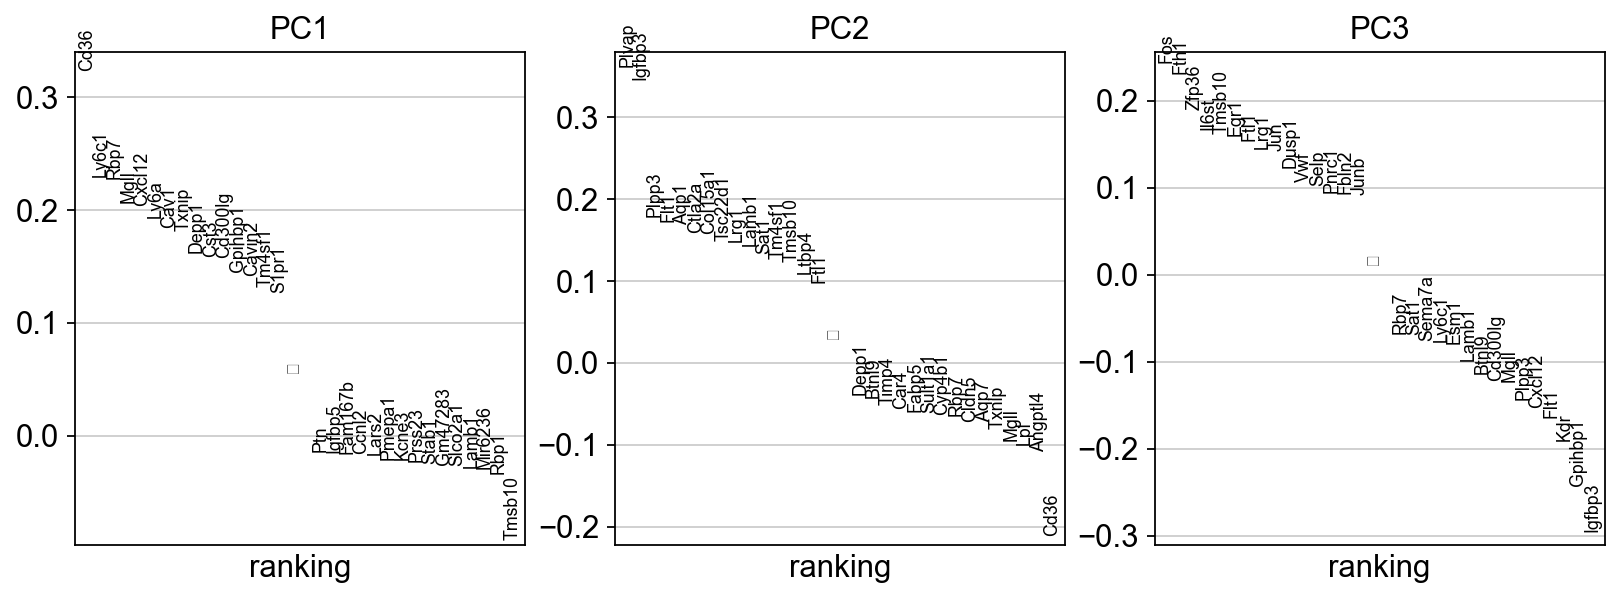

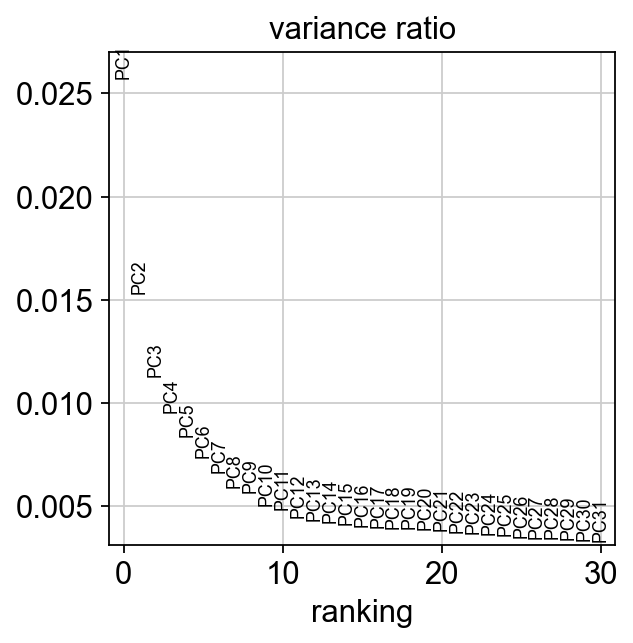

In [396]:
sc.pl.pca_overview(endo_adata)

In [397]:
sc.pp.neighbors(endo_adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [398]:
sc.tl.umap(endo_adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [399]:
sc.tl.leiden(endo_adata, resolution=0.5)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


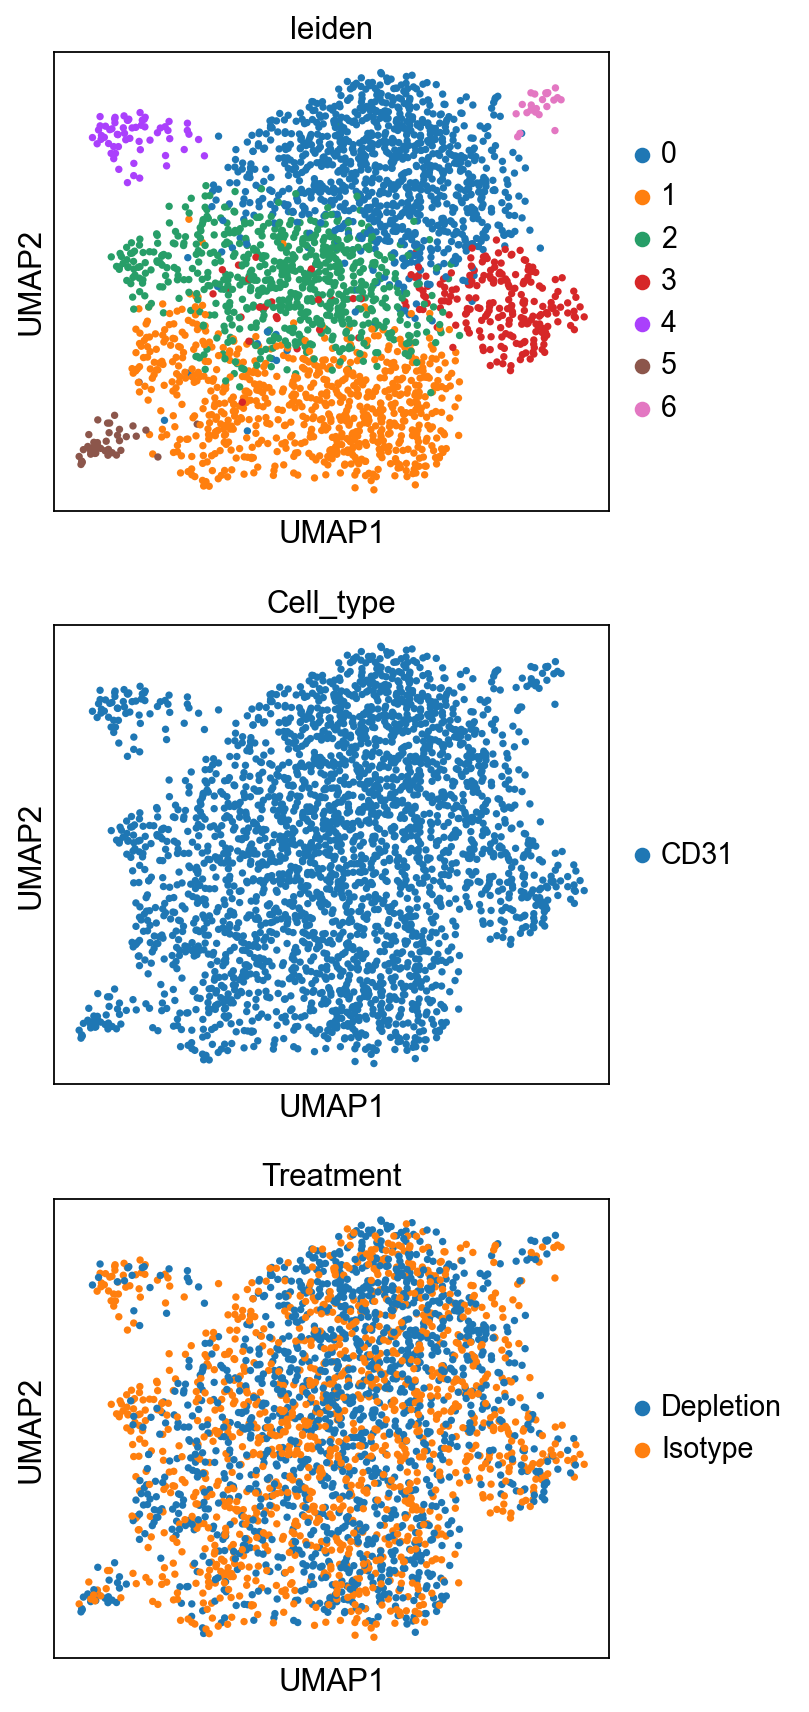

In [400]:
sc.pl.umap(endo_adata, color=['leiden', 'Cell_type', 'Treatment'], ncols=1)

In [281]:
sc.tl.rank_genes_groups(endo_adata, groupby='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [282]:
pd.DataFrame(endo_adata.uns["rank_genes_groups"]["names"][0:25])

0         1         2        3        4         5        6
0            Ncan      Cd36     Sparc     Lrg1   mt-Nd6      Rgs5     Flt4
1   2900089D17Rik     Fabp4    Col4a1    Il6st   mt-Nd2    Col6a3  Serinc3
2   9530078K11Rik      Rbp7    Col4a2     Aqp1   mt-Nd1    Pdgfrb      Cd9
3            Rorb     Ly6c1    Igfbp7    Plvap      Trf    Col5a3    Lyve1
4        AY036118      Ly6a     Lamb1     Ehd4   mt-Nd4     Plac9    Mmrn1
5           Ap4m1      Mgll     Calm1     Tpt1  mt-Cytb  Ndufa4l2  Slc45a3
6           Astn1     Txnip      Actb    Rps20   mt-Co1  Serping1    Ltbp4
7         Gm43484    Cxcl12      Cd34    Rplp1    Rps26     Anxa1   Rnase4
8         Gm37124   Cd300lg      Cd93  Gm11942    Rplp1      Aspn     Reln
9         Gm47625     Btnl9   Sparcl1      Vwf     Ldha    Rps3a1     Thy1
10          Cage1    Cavin2   Col15a1    Rps12    Rpl17     Kcnj8    Prelp
11        Gm43858      Aqp7      Mcam    Rpl12  Gm11942     Cald1    Timp2
12        Gm11633     Depp1     Fscn1    Rps17     Rpl4    Notch3      Maf
13  1700048O20Rik       Lpl       Vim   Ifitm3    Epcam    S100a6   Ccl21a
14        Gm45278      Cst3   Gpihbp1    Fbln2   Rpl37a     Prrx1   Mfsd4a
15         Gm5047     Epas1  Serpinh1     Rps5   Igfbp5  Tnfrsf21    Stab1
16        Gm37465      Srgn     Gnai2    Rpl26   Rps27a     Crip1    Cldn5
17          Doc2g     H2-D1    Tmsb4x    Rps16    Rpl28    Steap4     Canx
18        Gm14398  Slc9a3r2      Tpm4   Eef1b2    Rps17      Thy1     Fth1
19        Gm10721    Tspan7    Fkbp1a    Ackr1    Mgst1   S100a11     Wnk1
20        Gm49901    Adgrg1      Cfl1   Ctla2a    Rps19      Zeb2     Pdpn
21       Vaultrc5      Car4    Tmsb10    Rpl23    Rps18       Des     Add3
22        Gm37082      Cav1    Cavin3    Rps23    Rpl36    Higd1b      Lbp
23        Gm13653     S1pr1      Nid1    Rplp0    Plet1     Rpl21   Tgfbr2
24        Gm37728     Lims2    Marcks     Rpl9  Gm10051      Cd63      F2r

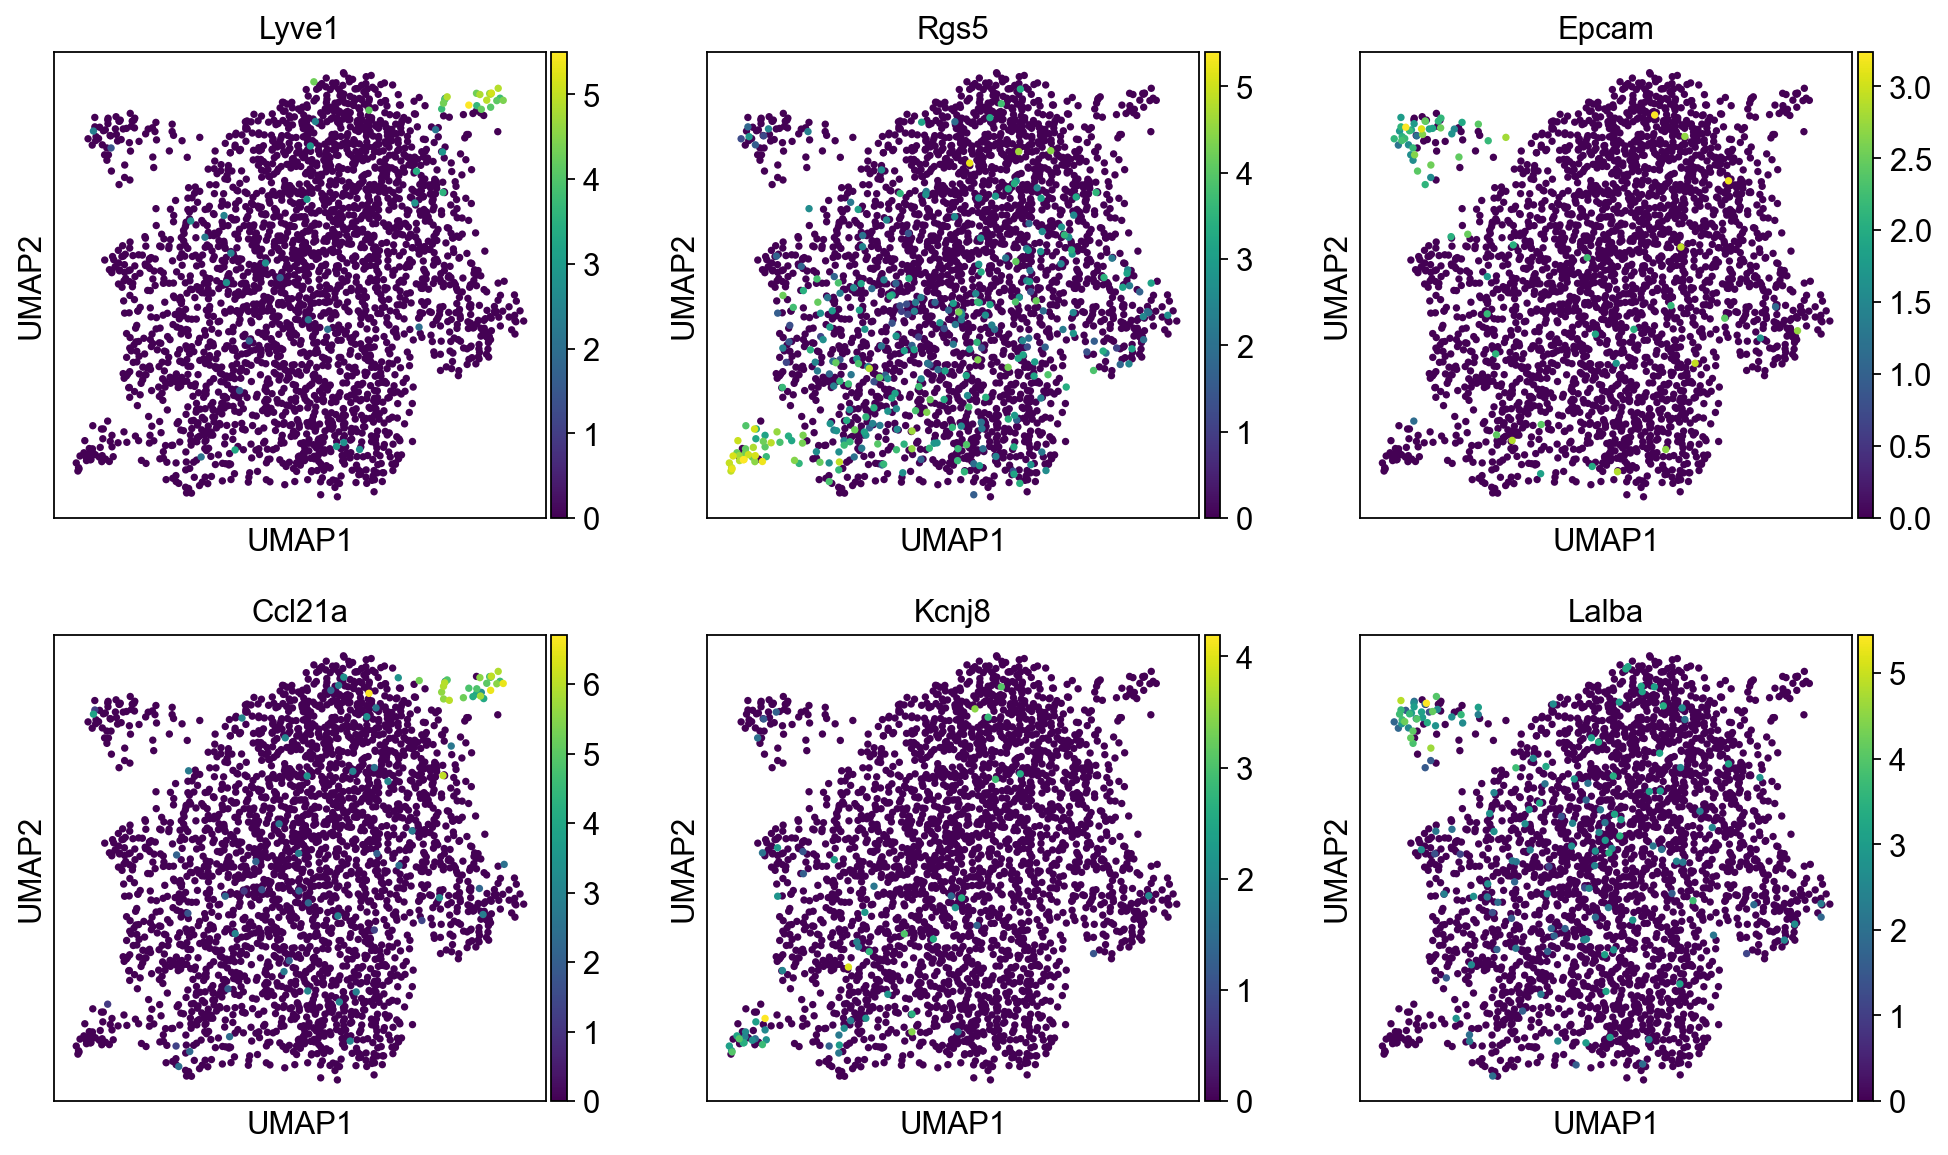

In [404]:
sc.pl.umap(endo_adata, color=['Lyve1', 'Rgs5', 'Epcam', 'Ccl21a', 'Kcnj8', 'Lalba'], ncols=3, use_raw=False, save="depletion_endo_genes.pdf")

In [406]:
endo_adata.obs['annots'] = ["Endothelial" if a in ["0", "1", "2", "3"] else "Bad" for a in endo_adata.obs.leiden]

... storing 'annots' as categorical


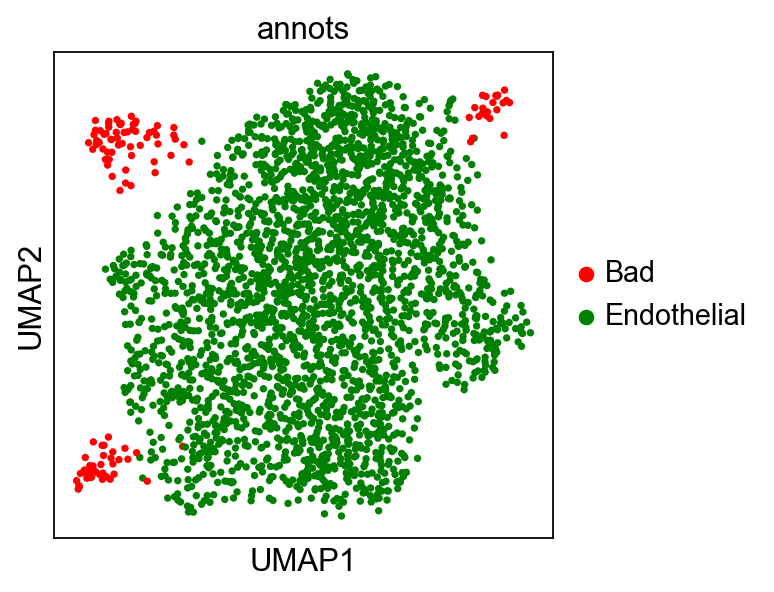

In [407]:
sc.pl.umap(endo_adata, color=['annots'], palette=['red', 'green'], save="depletion_endo_annots.pdf")

In [408]:
endo_adata = endo_adata[endo_adata.obs.leiden.isin(['0', '1', '2', '3'])]

In [409]:
sc.pp.filter_genes(endo_adata, min_counts=20)
sc.tl.rank_genes_groups(endo_adata, groupby='Treatment', method='t-test', use_raw=False)

filtered out 3583 genes that are detected in less than 20 counts
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [288]:
endo_gene_df = sc.get.rank_genes_groups_df(endo_adata, group='Isotype')

In [292]:
endo_gene_df.to_excel('depletion_dges/endo_new.xlsx')

In [289]:
endo_gene_df.set_index('names').loc[endo_plot_genes]

scores  logfoldchanges     pvals  pvals_adj
names                                               
S1pr1  3.983649        0.488742  0.000070   0.008437
Ndrg1  3.828822        0.564695  0.000132   0.014115
Aqp1   3.731275        0.440840  0.000195   0.016786
Rab7   4.751415        0.658771  0.000002   0.000540

In [290]:
endo_plot_genes = [
    #"Pdlim1", # facilitates metastasis https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4175366/
    "S1pr1",
    "Ndrg1", #https://www.nature.com/articles/s42003-020-0829-0
    #"Klf2", "Klf4", #TFs
    "Aqp1", #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3929666/
    "Rab7", #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5702662/
]

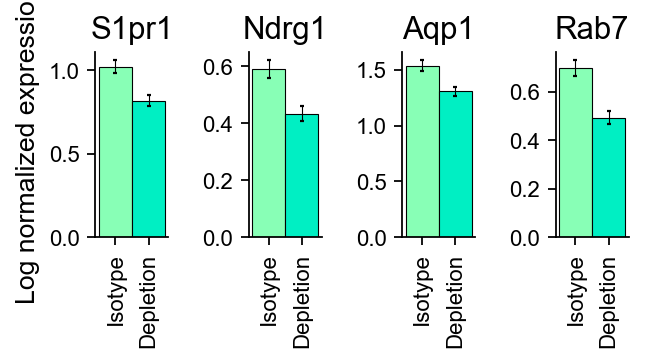

In [291]:
f = draw_barplot(endo_adata, 
                 endo_plot_genes, 
                 ['#88ffb6', '#00efc3'], tbl_name='endo_genes_new')
f.savefig('revision_figs/endo_genes_new.pdf')